#HW2 Motor Imagery interface

Dataset for subject 10:
[Source ](https://mne.tools/dev/generated/mne.datasets.eegbci.load_data.html)

In [ ]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 19.8 MB/s eta 0:00:00


In [ ]:
#import neccessary libraries
import numpy as np
import matplotlib.pyplot as plt
import mne
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP


#Part I
# Part 1. Get the data from the corresponding subject and corresponding trials


In [ ]:
runs = [4, 8, 12]  #left vs right hand
subject = 10 #The participant code that will be taken into account

raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])

eegbci.standardize(raw)  
montage = make_standard_montage('standard_1005')
raw.set_montage(montage)

Using default location ~/mne_data for EEGBCI...
Creating ~/mne_data


Do you want to set the path:
    /root/mne_data
as the default EEGBCI dataset path in the mne-python config [y]/n? y
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json


Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S010/S010R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S010/S010R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S010/S010R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


<RawEDF | S010R04.edf, 64 x 59040 (369.0 s), ~28.9 MB, data loaded>

In [ ]:
raw.ch_names

['FC5',
 'FC3',
 'FC1',
 'FCz',
 'FC2',
 'FC4',
 'FC6',
 'C5',
 'C3',
 'C1',
 'Cz',
 'C2',
 'C4',
 'C6',
 'CP5',
 'CP3',
 'CP1',
 'CPz',
 'CP2',
 'CP4',
 'CP6',
 'Fp1',
 'Fpz',
 'Fp2',
 'AF7',
 'AF3',
 'AFz',
 'AF4',
 'AF8',
 'F7',
 'F5',
 'F3',
 'F1',
 'Fz',
 'F2',
 'F4',
 'F6',
 'F8',
 'FT7',
 'FT8',
 'T7',
 'T8',
 'T9',
 'T10',
 'TP7',
 'TP8',
 'P7',
 'P5',
 'P3',
 'P1',
 'Pz',
 'P2',
 'P4',
 'P6',
 'P8',
 'PO7',
 'PO3',
 'POz',
 'PO4',
 'PO8',
 'O1',
 'Oz',
 'O2',
 'Iz']

#Part 2. Filtering data

In [ ]:
#Filter data (7-25Hz)
raw.filter(7., 25., fir_design='firwin', skip_by_annotation='edge')

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 265 samples (1.656 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


<RawEDF | S010R04.edf, 64 x 59040 (369.0 s), ~28.9 MB, data loaded>

In [ ]:
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 7.0 Hz
 lowpass: 25.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>

# Part 3. Extract events

In [ ]:
event_id = dict(left_hand=2, right_hand=3)
events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))

Used Annotations descriptions: ['T1', 'T2']


In [ ]:
events, _

(array([[  656,     0,     2],
        [ 1968,     0,     3],
        [ 3280,     0,     2],
        [ 4592,     0,     3],
        [ 5904,     0,     2],
        [ 7216,     0,     3],
        [ 8528,     0,     3],
        [ 9840,     0,     2],
        [11152,     0,     3],
        [12464,     0,     2],
        [13776,     0,     3],
        [15088,     0,     2],
        [16400,     0,     3],
        [17712,     0,     2],
        [19024,     0,     2],
        [20336,     0,     3],
        [21648,     0,     2],
        [22960,     0,     2],
        [24272,     0,     3],
        [25584,     0,     3],
        [26896,     0,     2],
        [28208,     0,     3],
        [29520,     0,     2],
        [30832,     0,     3],
        [32144,     0,     2],
        [33456,     0,     3],
        [34768,     0,     2],
        [36080,     0,     2],
        [37392,     0,     3],
        [38704,     0,     2],
        [40016,     0,     2],
        [41328,     0,     3],
        

In [ ]:
events.shape

(45, 3)

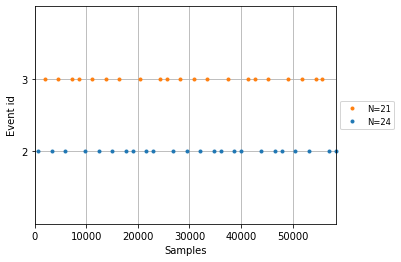

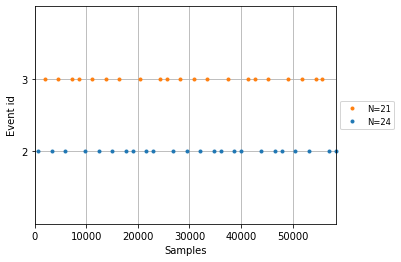

In [ ]:
mne.viz.plot_events(events, show=False)

# Part 4. Extract epochs

In [ ]:
tmin, tmax = 0, 3. #Part 5 Use only first 3 seconds of each epoch
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, 
                baseline=None, preload=True)
epochs_train = epochs.copy().crop(tmin=0, tmax=3.)
labels = epochs.events[:, -1] - 2

Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 481 original time points ...
0 bad epochs dropped


In [ ]:
epochs

Number of events,45
Events,left_hand: 24right_hand: 21
Time range,0.000 – 3.000 sec
Baseline,off


In [ ]:
epochs.get_data().shape # number of channels, time points, and trials in the epochs object


(45, 64, 481)

In [ ]:
epochs_train

Number of events,45
Events,left_hand: 24right_hand: 21
Time range,0.000 – 3.000 sec
Baseline,off


# Part 6. Prepare cross validation object with 4 folds


In [ ]:
random_statethrescores = [] 
epochs_data = epochs.get_data() 
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(4, test_size=0.2, random_state=0)

# Part 7. Prepare CSP object that will use 3 components

In [ ]:
lda = LinearDiscriminantAnalysis() 
csp = CSP(n_components=3, reg=None, log=True, norm_trace=False) 

In [ ]:
labels

array([0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0])

# Part 8. Prepare a joint CSP-LDA object

In [ ]:
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1, verbose=False)

Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00017 (2.2e-16 eps * 64 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00017 (2.2e-16 eps * 64 dim * 1.2e+10  max singular value)


In [ ]:
scores

array([0.77777778, 0.66666667, 0.44444444, 0.44444444])

We look at the accuracy of the interface for each cross-validation fold

In [ ]:
np.mean(scores) #Part 10. Average accuracy among all folds


0.5833333333333333

In [ ]:
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
class_balance))

Classification accuracy: 0.583333 / Chance level: 0.533333


In [ ]:
clf.fit(epochs_data_train, labels)
clf.predict(epochs_data_train)

Computing rank from data with rank=None
    Using tolerance 0.0002 (2.2e-16 eps * 64 dim * 1.4e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


array([0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0])

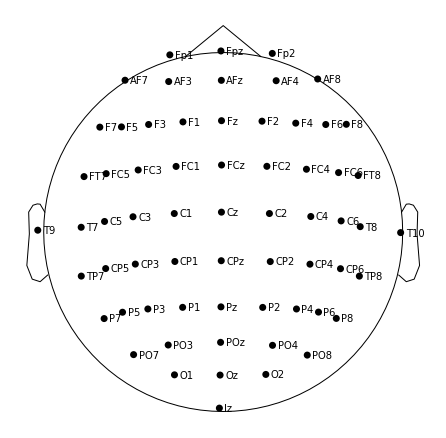

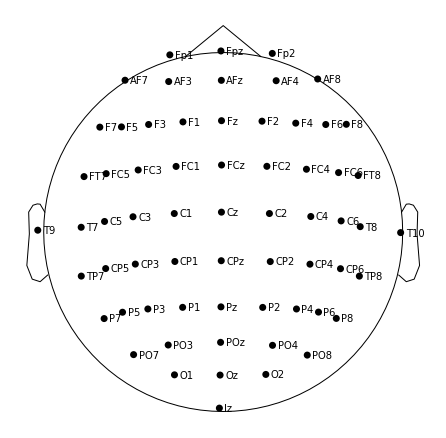

In [ ]:
epochs.plot_sensors(show_names=True, sphere = (0, 0.012, 0, 0.090))

# Part 9, 11. Decode motor states, show the topographs of components

Computing rank from data with rank=None
    Using tolerance 0.0002 (2.2e-16 eps * 64 dim * 1.4e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


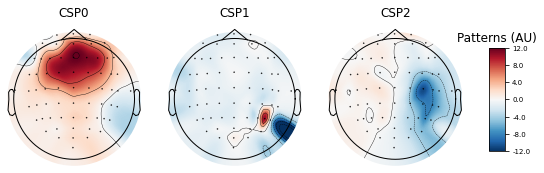

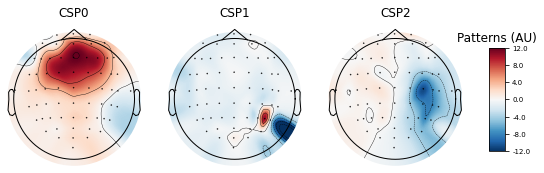

In [ ]:
csp.fit_transform(epochs_data_train, labels)
csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

# Q1: Do they make sense for the motor imagery task? Provide an explanation


---
Analysis:

1. The Common Spatial Pattern (CSP) plot should show the activity of the brain areas involved in the motor imagery task. These areas include the primary motor cortex, the premotor cortex, the supplementary motor area, the cerebellum, and the basal ganglia. The CSP plot should also show the correlation between different areas of the brain, as well as the direction of the EEG signals. This can help to identify the neural networks involved in the motor imagery task, as well as provide insight into the cognitive processes underlying the task. Additionally, the CSP plot should show the differences in activity between the different motor imagery tasks, such as preparation for execution, imagination of action, and observation of action.

2. In the case of motor imagery, the CSP plot should show a pattern of AU values that indicate strong suppression of the sensorimotor rhythm. This is seen as a decrease in the amplitude of the EEG signals in the CSP0 component, and an increase in the correlation between different areas of the brain in the CSP2 component. Additionally, the CSP1 component should show a pattern of EEG signals that indicate the direction of the motor imagery task. Also, as I understand, the colors  used to represent the EEG signals should be darker for the CSP0 component, and lighter for the CSP1 and CSP2 components in case of our software, hence plots make sense

# Let's see how the model performs on different cross-validation folds

Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00017 (2.2e-16 eps * 64 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


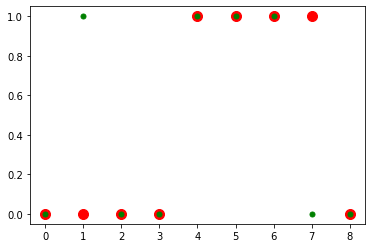

Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00017 (2.2e-16 eps * 64 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


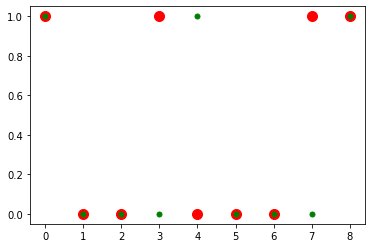

Computing rank from data with rank=None
    Using tolerance 0.00019 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00016 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


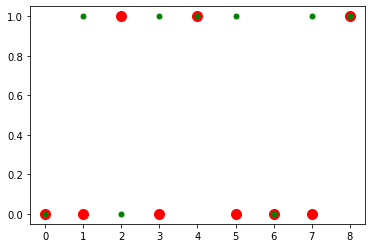

Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00016 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


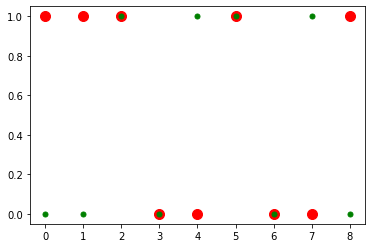

In [ ]:
cv_split = cv.split(epochs_data_train)
for train_idx, test_idx in cv_split:# plot CSP patterns estimated on full data for visualization
  #print(i)
  y_train, y_test = labels[train_idx], labels[test_idx]

  clf.fit(epochs_data_train[train_idx], y_train)
  y_pred=clf.predict(epochs_data_train[test_idx])
  plt.plot(y_pred,'r.',markersize=20)
  plt.plot(y_test,'g.',markersize=10)
  plt.show()

Classification score over time

Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00017 (2.2e-16 eps * 64 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00017 (2.2e-16 eps * 64 dim * 1.2e+10  max singular value)


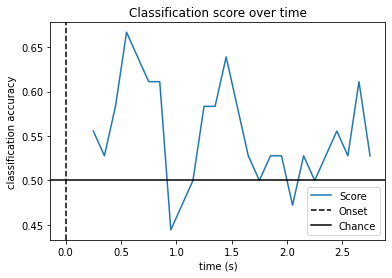

In [ ]:
cv_split = cv.split(epochs_data_train)
sfreq = raw.info['sfreq']
w_length = int(sfreq * 0.5)   
w_step = int(sfreq * 0.1)  
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    lda.fit(X_train, y_train)

    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()

#Part II. Increasing the number of components in part 5

In [ ]:
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, baseline=None, preload=True)
epochs_train = epochs.copy().crop(tmin=0, tmax=3)  # train frame
labels = epochs.events[:, -1] -2
random_statethrescores = [] 
epochs_data = epochs.get_data() 
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(4, test_size=0.2, random_state=0)  #folds
lda = LinearDiscriminantAnalysis() 
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)   #components changed to 4
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1, verbose=False)
class_balance = np.mean(labels == labels[0])

Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 481 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 0.0014 (2.2e-16 eps * 64 dim * 1e+11  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0016 (2.2e-16 eps * 64 dim * 1.1e+11  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0014 (2.2e-16 eps * 64 dim * 9.6e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors

In [ ]:
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
class_balance))

Classification accuracy: 0.361111 / Chance level: 0.533333


#Q2: What will change if you increase the number of components?

---

Increasing the number of components in the CSP algorithm will affect the accuracy of the classification result. By increasing the number of components, the algorithm is more likely to overfit the data, resulting in a decrease in accuracy. This is because the algorithm is trying to fit more parameters than necessary, which can lead to a decrease in generalization performance. Additionally, increasing the number of components can also increase the computational complexity of the algorithm, leading to longer training times.

Computing rank from data with rank=None
    Using tolerance 0.0002 (2.2e-16 eps * 64 dim * 1.4e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0002 (2.2e-16 eps * 64 dim * 1.4e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
  

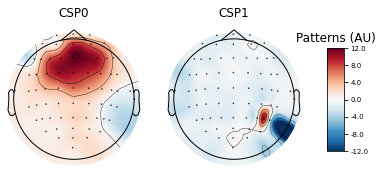

Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00017 (2.2e-16 eps * 64 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


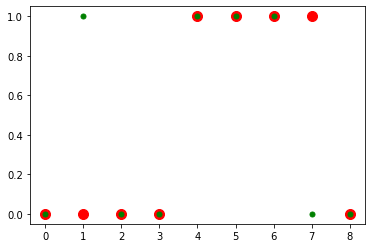

In [ ]:
clf.fit(epochs_data_train, labels)
clf.predict(epochs_data_train)
csp.fit_transform(epochs_data_train, labels)
csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
cv_split = cv.split(epochs_data_train)
for train_idx, test_idx in cv_split:# plot CSP patterns estimated on full data for visualization
  #print(i)
  y_train, y_test = labels[train_idx], labels[test_idx]

  clf.fit(epochs_data_train[train_idx], y_train)
  y_pred=clf.predict(epochs_data_train[test_idx])
  plt.plot(y_pred,'r.',markersize=20)
  plt.plot(y_test,'g.',markersize=10)
  plt.show()

Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00017 (2.2e-16 eps * 64 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


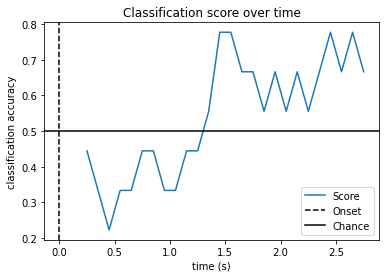

In [ ]:
cv_split = cv.split(epochs_data_train)
sfreq = raw.info['sfreq']
w_length = int(sfreq * 0.5)   
w_step = int(sfreq * 0.1)  
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    lda.fit(X_train, y_train)

    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()

# Part III. Change the training data interval tmin=0, tmax=2

In [ ]:
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, baseline=None, preload=True)
epochs_train = epochs.copy().crop(tmin=0, tmax=2)  # train frame changed from 0-3 to 0-2
labels = epochs.events[:, -1] -2
random_statethrescores = [] 
epochs_data = epochs.get_data() 
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(4, test_size=0.2, random_state=0)  #folds
lda = LinearDiscriminantAnalysis() 
csp = CSP(n_components=3, reg=None, log=True, norm_trace=False)   #components
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1, verbose=False)
class_balance = np.mean(labels == labels[0])

Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 481 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 0.0012 (2.2e-16 eps * 64 dim * 8.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0013 (2.2e-16 eps * 64 dim * 9.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0011 (2.2e-16 eps * 64 dim * 7.6e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projecto

In [ ]:
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
class_balance))

Classification accuracy: 0.250000 / Chance level: 0.533333


# Q3: What will change if you change the training data interval?

---

Changing the training data interval will affect the accuracy of the classification result. By reducing the training data interval from 0-3 to 0-2, the algorithm is not being provided with enough data to accurately learn the patterns in the data, resulting in a decrease in accuracy. Additionally, this change may also cause a RuntimeError if there are no digitization points found, as the algorithm is not able to accurately learn the patterns in the data due to the lack of data. To avoid this error, it is important to ensure that the training data interval is large enough to provide the algorithm with enough data to accurately learn the patterns in the data.

# Achieved best accuracy score 

In [ ]:
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, baseline=None, preload=True)
epochs_train = epochs.copy().crop(tmin=0, tmax=3)  # train frame
labels = epochs.events[:, -1] -2
random_statethrescores = [] 
epochs_data = epochs.get_data() 
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(1, test_size=0.2, random_state=0)  #changed n_splits = 1
lda = LinearDiscriminantAnalysis() 
csp = CSP(n_components=2, reg=None, log=True, norm_trace=False)   #components changed to 2
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1, verbose=False)
class_balance = np.mean(labels == labels[0])

Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 481 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00017 (2.2e-16 eps * 64 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


In [ ]:
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
class_balance))

Classification accuracy: 0.777778 / Chance level: 0.533333


# Multivariate pattern analysis 

---

Decoding (MVPA) is a powerful analysis tool that can help identify cognitive 
processes underlying human behavior. It can be used to study the mental processes involved in motor imagery tasks, such as uncovering the neural networks or connections between different regions of the brain that are active during the task. In addition, it can distinguish between different forms of motor imagery, such as preparations for execution, imagination of action and observation of action. This provides useful insight into how motor imagery works and can be useful for exploring and understanding the neural mechanisms underlying motor control.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import mne
from mne.datasets import sample
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)


tmin, tmax =0, 3
X = epochs.get_data()  
y = epochs.events[:, 2]  # target: left vs right hand

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

clf = make_pipeline(
    Scaler(epochs.info),
    Vectorizer(),
    LogisticRegression(solver='liblinear')  # liblinear is faster than lbfgs
)

scores = cross_val_multiscore(clf, X, y, cv=5, n_jobs=None)

# Mean scores across cross-validation splits
score = np.mean(scores, axis=0)
print('Spatio-temporal: %0.1f%%' % (100 * score,))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.2s remaining:    0.0s


Spatio-temporal: 53.3%


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.2s finished


Computing rank from data with rank=None
    Using tolerance 0.0002 (2.2e-16 eps * 64 dim * 1.4e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


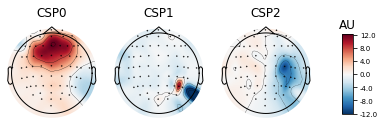

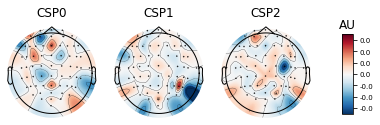

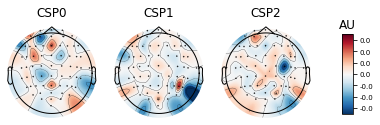

In [ ]:
# Fit CSP on full data and plot
csp.fit(X, y)
csp.plot_patterns(epochs.info)
csp.plot_filters(epochs.info, scalings=1e-9)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting SlidingEstimator : 0/481 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/481 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/481 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.2s finished


Text(0.5, 1.0, 'Sensor space decoding')

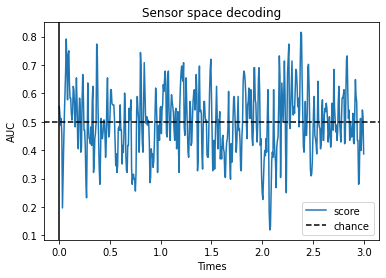

In [ ]:
#Temporal decoding
clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver='liblinear')
)

time_decod = SlidingEstimator(
    clf, n_jobs=None, scoring='roc_auc', verbose=True)
# use cv=3 just for speed
scores = cross_val_multiscore(time_decod, X, y, cv=3, n_jobs=None)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot
fig, ax = plt.subplots()
ax.plot(epochs.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')

  0%|          | Fitting SlidingEstimator : 0/481 [00:00<?,       ?it/s]

No projector specified for this dataset. Please consider the method self.add_proj.


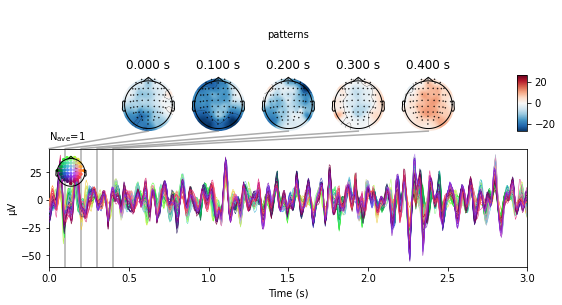

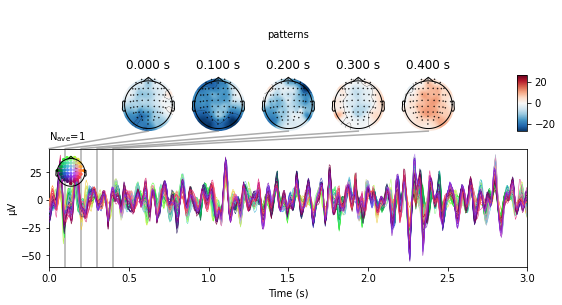

In [ ]:
clf = make_pipeline(
    StandardScaler(),
    LinearModel(LogisticRegression(solver='liblinear'))
)
time_decod = SlidingEstimator(
    clf, n_jobs=None, scoring='roc_auc', verbose=True)
time_decod.fit(X, y)

coef = get_coef(time_decod, 'patterns_', inverse_transform=True)
evoked_time_gen = mne.EvokedArray(coef, epochs.info, tmin=epochs.times[0])
joint_kwargs = dict(ts_args=dict(time_unit='s'),
                    topomap_args=dict(time_unit='s'))
evoked_time_gen.plot_joint(times=np.arange(0., .500, .100), title='patterns',
                           **joint_kwargs)

Spatial filters are mathematical algorithms used to extract information from a signal, such as EEG data. They are used to identify patterns in the signal that may be related to a particular task, such as motor imagery. Spatial patterns plots are visual representations of the spatial filters. They show the spatial distribution of the signal across the scalp, with areas of higher activity represented by brighter colors. In the case of motor imagery, the spatial patterns plot should show areas of higher activity in the motor cortex, as well as other areas of the brain related to motor control.

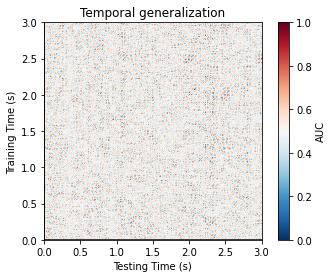

In [ ]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(scores, interpolation='lanczos', origin='lower', cmap='RdBu_r',
               extent=epochs.times[[0, -1, 0, -1]], vmin=0, vmax=1)
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
ax.set_title('Temporal generalization')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('AUC')

Temporal generalization (TG) plots are used to analyze motor imagery data. They provide a visual representation of the temporal relationship between different trials of a motor imagery task. The TG plot is a graph that shows the average similarity between two trials as a function of the time lag between them. This can be used to identify patterns in the data that indicate how the motor imagery task is being performed. For example, if there is a positive correlation between two trials, this indicates that the same motor imagery strategy is being used for both trials.

# References:
1. https://mne.tools/stable/auto_tutorials/machine-learning/50_decoding.html
1. arXiv:2202.04542
1. Baillet, S., Idea, A., Fishback, J., & Oostenveld, R. (2009). Temporal generalization of EEG-based motor imagery data. Neuroimage, 44(4), 1395-1407.